# Get started with TensorBoard

In [1]:
# Load the TensorBoard notebook extension
# pip install jupyter-tensorboard

%load_ext tensorboard

In [2]:
import tensorflow as tf
import datetime

print("The version of Tensorflow: {}".format(tf.__version__))

The version of Tensorflow: 2.4.1


In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

## 1. Using TensorBoard with Keras Model.fit()

In [4]:
# Place the logs in a timestamped subdirectory to allow easy selection of different training runs.

model = create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=x_train, 
          y=y_train, 
          epochs=5, 
          validation_data=(x_test, y_test), 
          callbacks=[tensorboard_callback])

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3610 - accuracy: 0.8938 - val_loss: 0.1046 - val_accuracy: 0.9680
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0965 - accuracy: 0.9704 - val_loss: 0.0852 - val_accuracy: 0.9721
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0686 - accuracy: 0.9788 - val_loss: 0.0878 - val_accuracy: 0.9731
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0527 - accuracy: 0.9827 - val_loss: 0.0644 - val_accuracy: 0.9796
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0407 - accuracy: 0.9865 - val_loss: 0.0680 - val_accuracy: 0.9798


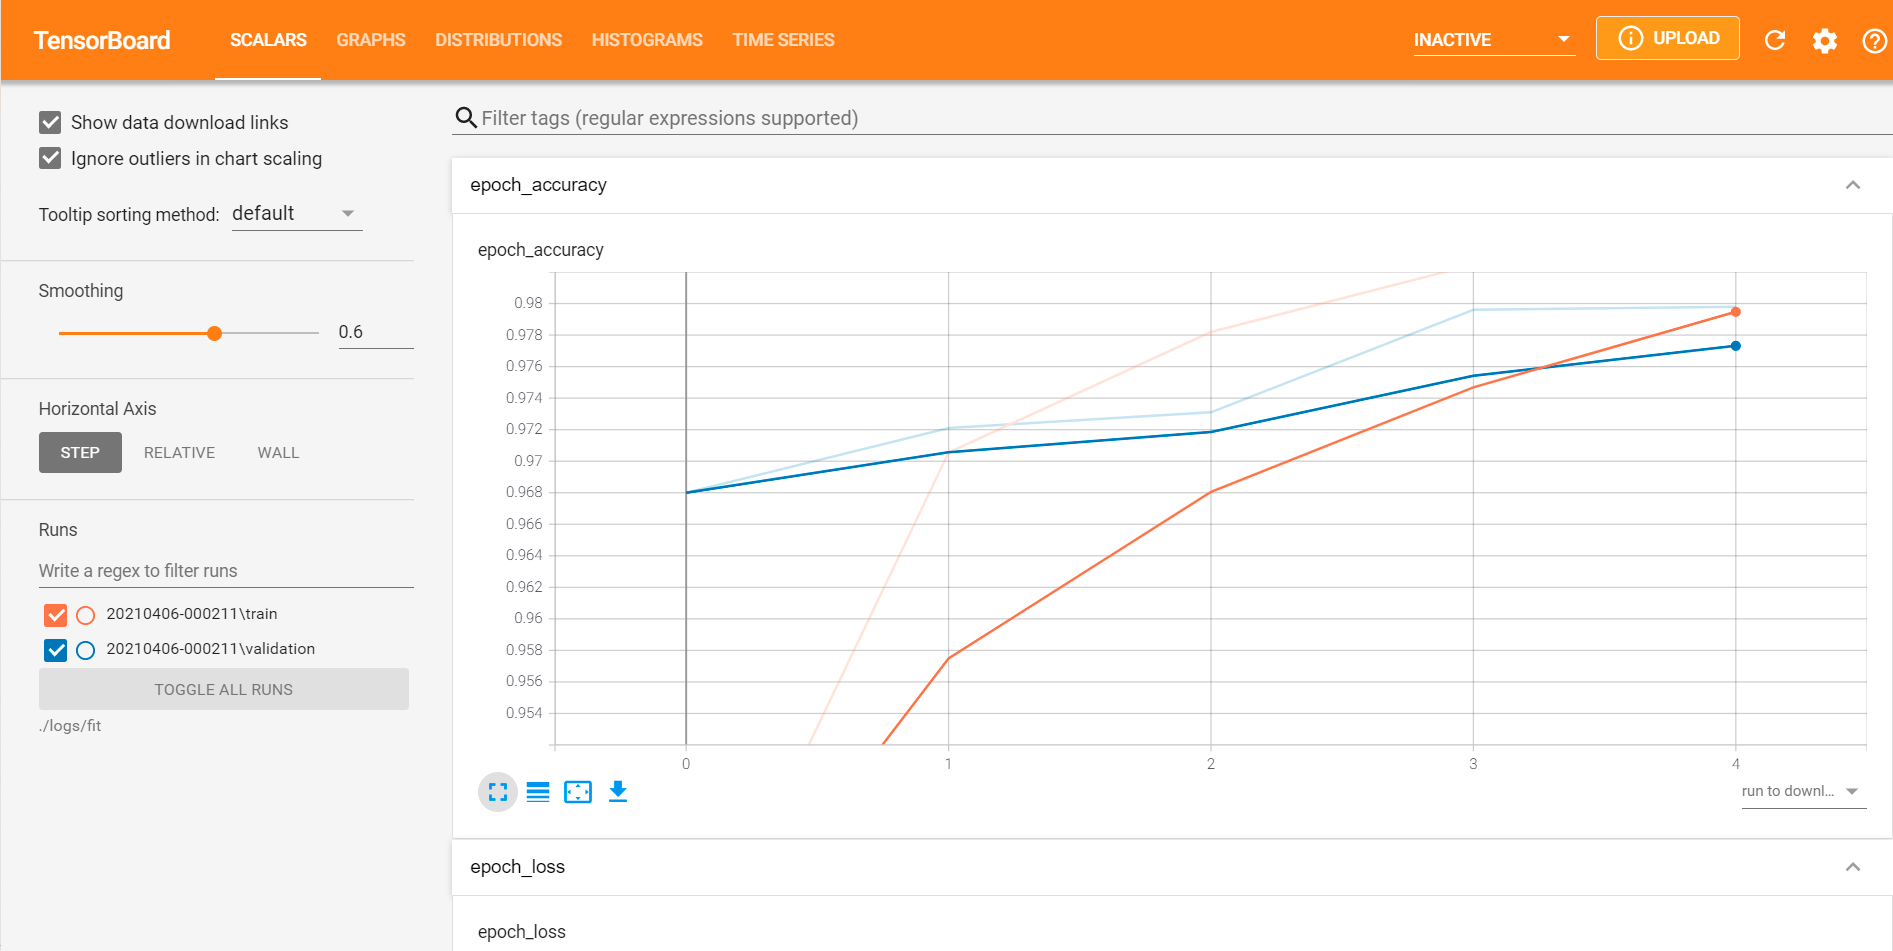

In [7]:
from IPython.display import Image, display
display(Image(filename="./image/firstBoard.png", embed=True))

### A **brief overview** of the dashboards shown (tabs in top navigation bar):

- The **Scalars** dashboard shows how the loss and metrics change with every epoch. You can use it to also track training speed, learning rate, and other scalar values.

- The **Graphs** dashboard helps you visualize your model. In this case, the Keras graph of layers is shown which can help you ensure it is built correctly.

- The **Distributions and Histograms** dashboards show the distribution of a Tensor over time. This can be useful to visualize weights and biases and verify that they are changing in an expected way.


Additional TensorBoard plugins are **automatically** enabled when you log other types of data. For example, the Keras TensorBoard callback lets you log images and embeddings as well. You can see what other plugins are available in TensorBoard by clicking on the **"inactive" dropdown** towards the top right.

## 2. Using TensorBoard with other methods

In [8]:
# Use the same dataset as above, but convert it to tf.data.Dataset to take advantage of batching capabilities:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_dataset = train_dataset.shuffle(60000).batch(64)
test_dataset = test_dataset.batch(64)

In [9]:
# The training code follows the advanced quickstart tutorial, 
# but shows how to log metrics to TensorBoard. Choose loss and optimizer:

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [10]:
# Create stateful metrics that can be used to accumulate values during training and logged at any point:

# Define our metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')

In [11]:
# Define the training and test functions:

def train_step(model, optimizer, x_train, y_train):
  with tf.GradientTape() as tape:
    predictions = model(x_train, training=True)
    loss = loss_object(y_train, predictions)
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  train_loss(loss)
  train_accuracy(y_train, predictions)

def test_step(model, x_test, y_test):
  predictions = model(x_test)
  loss = loss_object(y_test, predictions)

  test_loss(loss)
  test_accuracy(y_test, predictions)

In [12]:
# Set up summary writers to write the summaries to disk in a different logs directory:

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = './logs/gradient_tape/' + current_time + '/train'
test_log_dir = './logs/gradient_tape/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [13]:
model = create_model() # reset our model

EPOCHS = 5

for epoch in range(EPOCHS):
  for (x_train, y_train) in train_dataset:
    train_step(model, optimizer, x_train, y_train)
  with train_summary_writer.as_default():
    tf.summary.scalar('loss', train_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

  for (x_test, y_test) in test_dataset:
    test_step(model, x_test, y_test)
  with test_summary_writer.as_default():
    tf.summary.scalar('loss', test_loss.result(), step=epoch)
    tf.summary.scalar('accuracy', test_accuracy.result(), step=epoch)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_loss.result(), 
                         train_accuracy.result()*100,
                         test_loss.result(), 
                         test_accuracy.result()*100))

  # Reset metrics every epoch
  train_loss.reset_states()
  test_loss.reset_states()
  train_accuracy.reset_states()
  test_accuracy.reset_states()

Epoch 1, Loss: 0.24514000117778778, Accuracy: 92.90999603271484, Test Loss: 0.11223970353603363, Test Accuracy: 96.55000305175781
Epoch 2, Loss: 0.1058342307806015, Accuracy: 96.82833862304688, Test Loss: 0.08438099175691605, Test Accuracy: 97.47999572753906
Epoch 3, Loss: 0.07291153073310852, Accuracy: 97.76499938964844, Test Loss: 0.07000432908535004, Test Accuracy: 97.79999542236328
Epoch 4, Loss: 0.05584188923239708, Accuracy: 98.25999450683594, Test Loss: 0.06530822813510895, Test Accuracy: 98.0199966430664
Epoch 5, Loss: 0.04368448257446289, Accuracy: 98.61666870117188, Test Loss: 0.064207524061203, Test Accuracy: 98.08999633789062


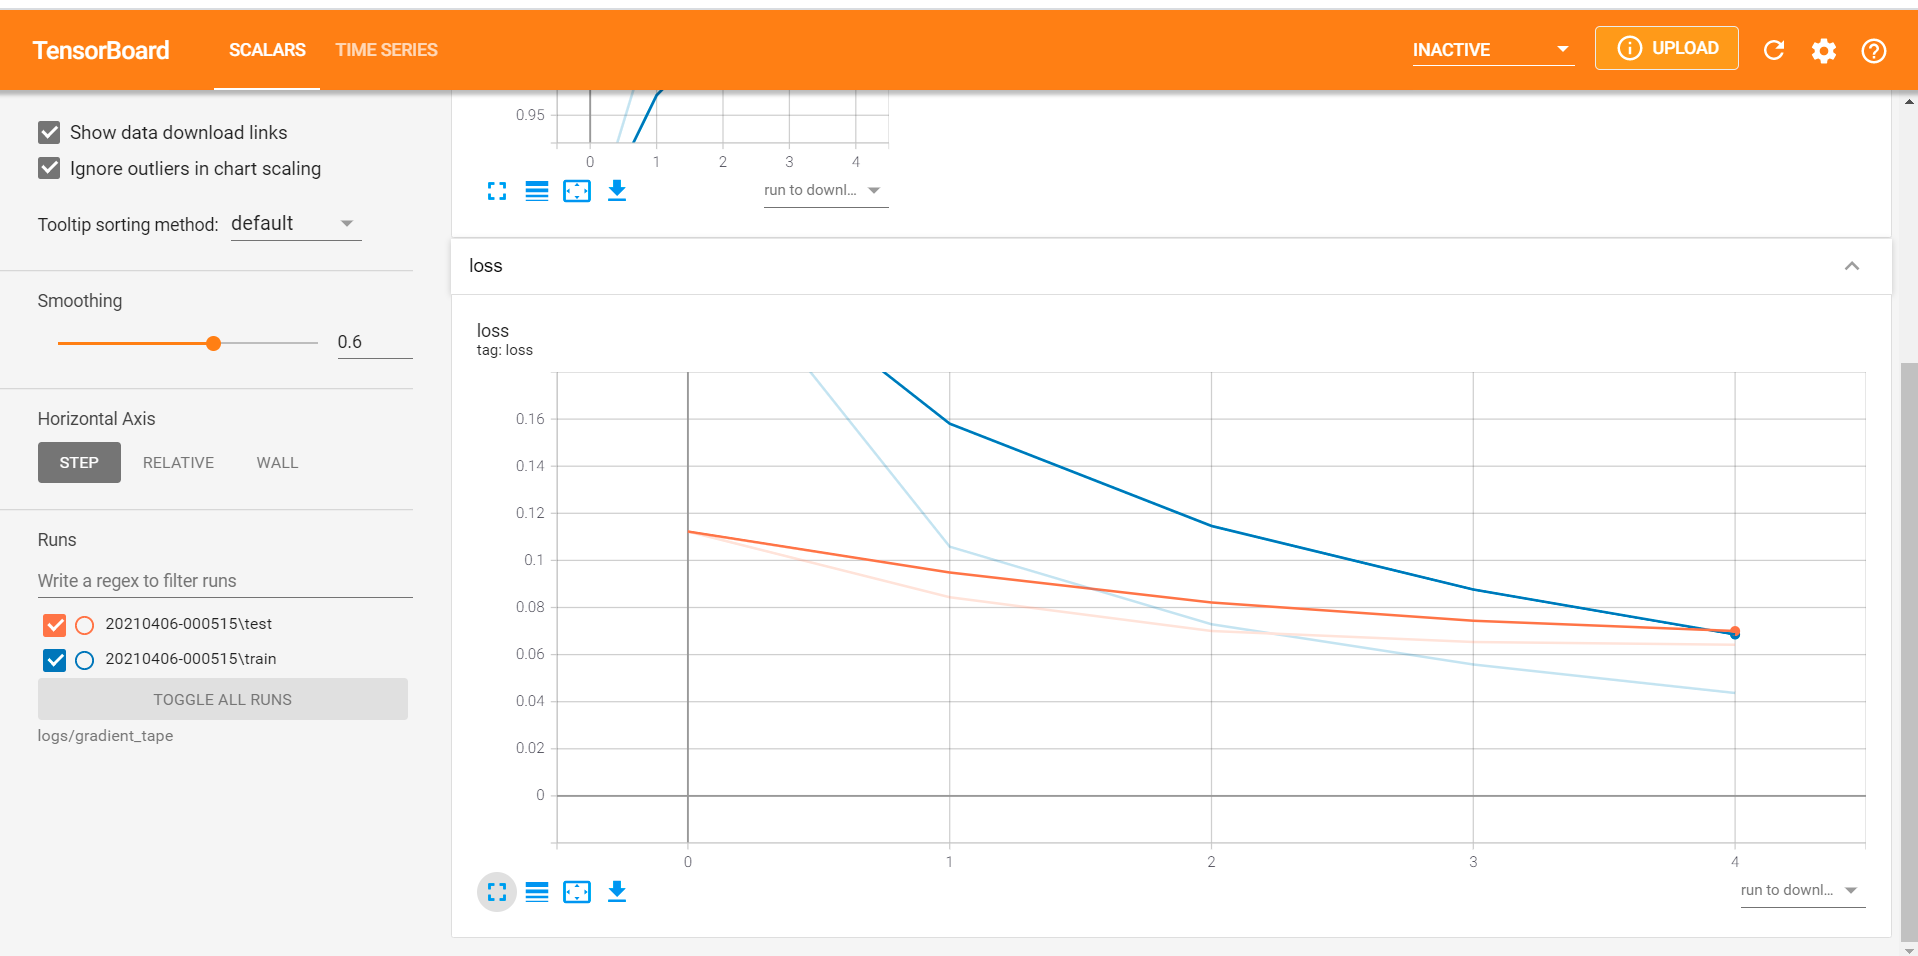

In [17]:
from IPython.display import Image, display
display(Image(filename="./image/firstBoard2.png", embed=True))

## 3. TensorBoard.dev: Host and share your ML experiment results

# reference

### https://tensorflow.google.cn/tensorboard/get_started